#### Импорт необходимых объектов

In [1]:
import os
import csv
import numpy as np
from scipy.interpolate import splrep, splev

from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import QuantileRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import RidgeCV, LassoCV, LassoLarsCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import NuSVR, SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor

import matplotlib.pyplot as plt

#### Функция чтения набора данных

In [2]:
def get_river_dataset(fname, pr_list=None, y_name='H_max'):
    pr_arr = []
    y_arr = []
    with open(fname, newline='') as f:
        reader = csv.DictReader(f, delimiter=';')
        for row in reader:
            pr_arr_row = []
            for pr in pr_list:
                pr_arr_row.append(row[pr])

            pr_arr.append(pr_arr_row)
            y_arr.append(row[y_name])
    X = np.asarray(pr_arr, dtype=np.float64)
    y = np.asarray(y_arr, dtype=np.float64)
    return X, y

#### Сумма, средний, высший, низший уровни

In [3]:
def get_sum(h_max):
    return np.sum(h_max)
    
def get_avg(h_max):
    return np.mean(h_max)
    
def get_max(h_max):
    return np.amax(h_max)
    
def get_min(h_max):
    return np.amin(h_max)

#### Среднеквадратическая погрешность прогноза S

In [4]:
def get_s(h_max, h_forecast):
    # Среднеквадратическая погрешность прогноза
    n = h_max.shape[0]
    sqr_diff = np.sum((h_max - h_forecast) ** 2) / (n - 1)
    std = sqr_diff ** 0.5
    return std    

#### Среднеквадратическое отклонение sigma

In [5]:
def get_sigma(h_max):
    # Среднеквадратическая погрешность климатическая.
    # Рассчитывается только по всей совокупности данных.
    return np.std(h_max, ddof=1)

#### Среднее значение максимальных уровней воды

In [6]:
def get_hmax_avg(h_max):
    # Среднее значение h_max.
    # Рассчитывается только по всей совокупности данных.
    return np.mean(h_max)

#### Допустимая погрешность прогноза delta_dop

In [7]:
def get_delta_dop(sigma):
    return 0.674 * sigma

#### Критерий критерий применимости и качества методики S/sigma

In [8]:
def get_criterion(s, sigma):
    return s / sigma

#### Климатическая обеспеченность Pk

In [9]:
def get_pk(h_max, h_max_avg, delta_dop):
    diff = np.abs(h_max - h_max_avg) / delta_dop
    trusted_values = diff[diff <= 1.0]
    m = trusted_values.shape[0]
    n = h_max.shape[0]
    return m / n * 100.00

#### Обеспеченность метода (оправдываемость) Pm

In [10]:
def get_pm(h_max, h_forecast, delta_dop):
    diff = np.abs(h_max - h_forecast) / delta_dop
    trusted_values = diff[diff <= 1.0]
    m = trusted_values.shape[0]
    n = h_max.shape[0]
    return m / n * 100.00

#### Корреляционное отношение

In [11]:
def get_correlation_ratio(criterion):
    c_1 = (1 - criterion ** 2)
    ro = c_1 ** 0.5 if c_1 > 0 else 0
    return ro

#### Вероятная ошибка прогноза S'

In [12]:
def get_forecast_error(s):
    return 0.674 * s

#### Ошибки климатического/природного прогноза для каждого года delta50

In [13]:
def get_delta50(h_max, delta_dop, h_max_avg=None, h_max_forecast=None):
    if h_max_forecast is None:
        # delta50 климатическая
        return (h_max - h_max_avg) / delta_dop
    else:
        # delta50 прогноза
        return (h_max - h_max_forecast) / delta_dop
  

#### Функция записи списка моделей с их характеристиками в csv файл

In [14]:
def write_dataset_csv(dataset, dataset_name, fieldnames, pr_group):
    with open(
        f'results/{dataset_name}/group-{pr_group}/'
        f'{dataset_name}-гр{pr_group}.csv', 
        'w', newline='', encoding='utf-8'
    ) as csvfile:
        
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, 
                                delimiter=';', extrasaction='ignore')
        writer.writeheader()
        writer.writerows(dataset)


#### Функция записи результатов экспериментов в csv файл

In [15]:
def write_experiment_csv(dataset, fieldnames, filename):
    fpath = f'results/{filename}.csv'
    with open(fpath, 'a', newline='') as csvfile: #, encoding='cp1251'
        
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames, 
                                delimiter=';', extrasaction='ignore')
        fsize = os.stat(fpath).st_size
        if not fsize:
            writer.writeheader()
        writer.writerows(dataset)


#### Функция разделения набора данных на тренировочный и тестовый

In [16]:
def train_test_split(X, y, n_test, shuffle=False):
    if shuffle:
        # Перемешивание данных
        Xy = np.column_stack((X, y))
        rng = np.random.default_rng()
        rng.shuffle(Xy)
        y = Xy[:, -1]
        X = Xy[:,:-1]
        
    X_train = X[:-n_test]
    y_train = y[:-n_test]
    X_test = X[-n_test:]
    y_test = y[-n_test:]
    return X_train, y_train, X_test, y_test

#### Функция формирования тестового набора данных с подстановкой нормированных значений

In [17]:
def test_norm(x, pr_list, norms):
    x_norm = np.copy(x)
    for col, pr in enumerate(pr_list):
        if pr in norms:
            x_norm[:, col:col+1] = norms[pr]
    return x_norm

#### Функция получения датасетов

In [18]:
def get_datasets():
    datasets = {
        # 'Неман-Белица': 'Неман',
        # 'Неман-Гродно': 'Неман',
        'Неман-Мосты': 'Неман',
        # 'Неман-Столбцы': 'Неман',
    }
    return datasets

#### Функция получения списка предикторов по названию датасета

In [19]:
def get_predictors(dataset_name, pr_group):

    datasets = get_datasets()   
    predictors_lists = {
        'Неман': (
            ['S_2802', 'Smax', 'H_2802', 'X', 'X1', 'X2', 'X3', 'Xs'],
            ['Smax', 'H_2802', 'X', 'X1', 'X3'],
            ['S_2802', 'H_2802', 'X2', 'X3', 'Xs'],
        )
    }
    return predictors_lists[datasets[dataset_name]][pr_group]
    

#### Функция получения нормированных значений предикторов

In [20]:
def get_norms(dataset_name):
    norms_list = {
        'Неман-Белица': {'X1': 46.0, 'X2':35.0},
        'Неман-Гродно': {'X1': 36.0, 'X2':26.0},
        'Неман-Мосты': {'X1': 40.0, 'X2':31.0},
        'Неман-Столбцы': {'X1': 43.0, 'X2':34.0},
    }
    return norms_list[dataset_name]

    

#### Функция получения аугментированных данных

In [21]:
def augment_data(x_data, y_data, aug_n, aug_pow=2, s=None):
    #print(x_data)
    data_len = len(y_data)
    
    x_points = np.linspace(0, data_len, data_len)
    
    x_splitted = np.hsplit(x_data, x_data.shape[1])
    #print(x_splitted)

    x_list = []
    for arr in x_splitted:
        x_spl = splrep(x_points, arr, k=aug_pow, s=s)
        x_points_n = np.linspace(0, data_len, aug_n)
        x_col_augmented = splev(x_points_n, x_spl)
        x_list.append(x_col_augmented)
    x_augmented = np.array(x_list).T
    #print(x_augmented)

    y_points = np.linspace(0, data_len, data_len)
    y_spl = splrep(y_points, y_data, k=aug_pow, s=s)
    y_points_n = np.linspace(0, data_len, aug_n)
    y_augmented = splev(y_points_n, y_spl)
    #print(y_augmented)

    plt.plot(y_points, y_data, 'o', y_points_n, y_augmented)
    plt.plot(x_points, x_data[:, 0], 'x', x_points_n, x_augmented[:, 0])
    plt.show()
    
    return x_augmented, y_augmented

#### Функция обучения и оценки моделей

In [22]:
def compare_models(pr_group, n_test=None, norms=True, top_best=None, aug_n=0, aug_pow=2, grid_search=False, scaler=None, verify_forecast=True):
    
    ds_dir = 'data'
    
    names = [
        'LinearRegression',
        'Ridge',
        # ---Lasso,
        # # 'ElasticNet',
        # # 'Lars1',
        # # 'Lars2',
        # # 'Lars3',
        # 'Lars4',
        # 'Lars5',
        # 'Lars6',
        # 'Lars7',
        # 'Lars8',
        # # 'Lars9',
        # ---LassoLars,
        # # 'OMP1',
        # # 'OMP2',
        # # 'OMP3',
        # 'OMP4',
        # 'OMP5',
        # 'OMP6',
        # 'OMP7',
        # 'OMP8',
        # # 'OMP9',
        # # 'BayesianRidge',
        # # 'ARDRegression',
        # # 'SGDRegressor', 
        # # 'PassiveAggressiveRegressor',
        # # 'HuberRegressor',
        # # 'TheilSenRegressor',
        # # 'QuantileRegressor',
        
        'RidgeCV',
        'LassoCV',
        'LassoLarsCV',
        
        'KNeighborsRegressor',
        'NuSVR',
        'SVR',
        'MLPRegressor',
        
        # 'RandomForestRegressor',
        # 'ExtraTreesRegressor',
        # 'HistGradientBoostingRegressor',
        # 'BaggingRegressor',
        # 'VotingRegressor',
        # 'StackingRegressor',
        # 'StackingRegressorRidge',
        # 'AdaBoostRegressor',
    ]

    # Инициализация генератора случайных чисел для
    # для обеспечения воспроизводимости результатов
    rng = np.random.RandomState(0)

    # Наборы гиперпараметров моделей для алгоритма кроссвалидации
    # Гиперпараметры для Ridge, Lasso, ElasticNet, LassoLars, HuberRegressor
    alphas = np.logspace(-4, 3, num=100)
    
    # Гиперпараметры для ElasticNet
    l1_ratio = np.linspace(0.01, 1.0, num=50)
    
    # Гиперпараметры для BayesianRidge
    alphas_init = np.linspace(0.5, 2, 5)
    lambdas_init = np.logspace(-3, 1, num=5)
    
    # Гиперпараметры для ARDRegression
    alphas_lambdas = np.logspace(-7, -4, num=4)
    
    # Гиперпараметры для SGDRegressor
    losses = ['squared_error', 'huber', 
              'epsilon_insensitive', 'squared_epsilon_insensitive']
    sgd_alphas = np.logspace(-4, 1, num=100)
   
    # Гиперпараметры для PassiveAggressiveRegressor
    cc = np.linspace(0.1, 1.5, 50)
    
    # Гиперпараметры для HuberRegressor
    epsilons = np.append(np.linspace(1.1, 2.0, 10), [1.35])
    
    # Гиперпараметры для TheilSenRegressor
    n_subsamples = np.arange(6, 24)
    
    # Гиперпараметры для QuantileRegressor
    q_alphas = np.linspace(0, 2, 20)    
           
    
    regressors = [
        LinearRegression(),

        Ridge(random_state=rng) if not grid_search else \
        GridSearchCV(
            estimator=Ridge(random_state=rng), 
            param_grid={"alpha": alphas}
        ),
        
        # ---Lasso(max_iter=10000, random_state=rng) if not grid_search else \
        # GridSearchCV(
        #     estimator=Lasso(max_iter=10000, random_state=rng), 
        #     param_grid={"alpha": alphas}
        # ),
        
        # # ElasticNet(random_state=rng) if not grid_search else \
        # # GridSearchCV(
        # #     estimator=ElasticNet(random_state=rng), 
        # #     param_grid={"alpha": alphas, "l1_ratio": l1_ratio}, 
        # #     n_jobs=-1
        # # ),
        
        # # Lars(n_nonzero_coefs=1),
        # # Lars(n_nonzero_coefs=2),
        # # Lars(n_nonzero_coefs=3),
        # Lars(n_nonzero_coefs=4),
        # Lars(n_nonzero_coefs=5),
        # Lars(n_nonzero_coefs=6),
        # Lars(n_nonzero_coefs=7),
        # Lars(n_nonzero_coefs=8),
        
        # ---LassoLars(random_state=rng) if not grid_search else \
        # GridSearchCV(
        #     estimator=LassoLars(random_state=rng), 
        #     param_grid={"alpha": alphas}
        # ),
        
        # # OrthogonalMatchingPursuit(n_nonzero_coefs=1),
        # # OrthogonalMatchingPursuit(n_nonzero_coefs=2),
        # # OrthogonalMatchingPursuit(n_nonzero_coefs=3),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=4),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=5),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=6),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=7),
        # OrthogonalMatchingPursuit(n_nonzero_coefs=8),
        # # OrthogonalMatchingPursuit(n_nonzero_coefs=9),
        
        # # BayesianRidge() if not grid_search else \
        # # GridSearchCV(
        # #     estimator=BayesianRidge(),
        # #     param_grid={"alpha_init": alphas_init, "lambda_init": lambdas_init}, 
        # #     n_jobs=-1
        # # ),

        # # ARDRegression() if not grid_search else \
        # # GridSearchCV(
        # #     estimator=ARDRegression(), 
        # #     param_grid={"alpha_1": alphas_lambdas, "alpha_2": alphas_lambdas,
        # #                 "lambda_1": alphas_lambdas,"lambda_2": alphas_lambdas}, 
        # #     n_jobs=-1
        # # ),

        # # SGDRegressor(random_state=rng) if not grid_search else \
        # # GridSearchCV(
        # #     estimator=SGDRegressor(random_state=rng), 
        # #     param_grid={"loss": losses, "alpha": sgd_alphas}, 
        # #     n_jobs=-1
        # # ),

        # # PassiveAggressiveRegressor(random_state=rng) if not grid_search else \
        # # GridSearchCV(
        # #     estimator=PassiveAggressiveRegressor(random_state=rng), 
        # #     param_grid={"C": cc}, 
        # #     n_jobs=-1, 
        # #     cv=3
        # # ),

        # # HuberRegressor() if not grid_search else \
        # # GridSearchCV(
        # #     estimator=HuberRegressor(), 
        # #     param_grid={"epsilon": epsilons, "alpha": alphas}, 
        # #     n_jobs=-1 
        # # ),

        # # TheilSenRegressor(random_state=rng) if not grid_search else \
        # # GridSearchCV(
        # #     estimator=TheilSenRegressor(random_state=rng), 
        # #     param_grid={"n_subsamples": n_subsamples}, 
        # #     n_jobs=-1
        # # ),
        
        # # QuantileRegressor() if not grid_search else \
        # # GridSearchCV(
        # #     estimator=QuantileRegressor(), 
        # #     param_grid={"alpha": q_alphas}, 
        # #     n_jobs=-1
        # # ),

        RidgeCV(),
        LassoCV(max_iter=10000, n_alphas=300, random_state=0),
        LassoLarsCV(max_iter=1000, max_n_alphas=1000),
        
        KNeighborsRegressor(n_neighbors=10, metric='euclidean'),
        NuSVR(C=5.0, nu=0.9, kernel='poly', degree=3),
        SVR(C=5.0, epsilon=0.2, kernel='poly', degree=3),
        
        
        MLPRegressor(
            hidden_layer_sizes=(3, ), 
            activation='identity', 
            max_iter=100000, 
            early_stopping=True, 
            learning_rate='constant',
            learning_rate_init=0.00025,
            batch_size=75,
            solver='adam',
            random_state=0
        )
       
        
        
        # RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0),
        # ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0),
        # HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0),
        # BaggingRegressor(
        #     #KNeighborsRegressor(n_neighbors=20, metric='euclidean'),
        #     estimator=ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0), 
        #     max_samples=0.75, max_features=0.75, n_estimators=10, random_state=0
        # ),

        # VotingRegressor(
        #     estimators=[
        #         ('hgbr', HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0)), 
        #         ('omp', ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0)), 
        #         ('knr', KNeighborsRegressor(n_neighbors=20, metric='euclidean')),
        #         ('rfr', RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)),
        #     ]
        # ),

        # StackingRegressor(
        #     estimators=[
        #         ('knr', KNeighborsRegressor(n_neighbors=10, metric='euclidean')),
        #         ('rfr', RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)),
        #         ('hgbr', HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0)), 
        #         ('etr', ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0)),
        #         ('omp', OrthogonalMatchingPursuit(n_nonzero_coefs=6)),
        #     ],
        #     final_estimator=HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0)
        # ),

        # StackingRegressor( # RidgeCV - final estimator
        #     estimators=[
        #         ('knr', KNeighborsRegressor(n_neighbors=10, metric='euclidean')),
        #         ('rfr', RandomForestRegressor(n_estimators=100, criterion='absolute_error', random_state=0)),
        #         ('hgbr', HistGradientBoostingRegressor(max_iter=100, loss='absolute_error', max_leaf_nodes=None, min_samples_leaf=10, random_state=0)), 
        #         ('etr', ExtraTreesRegressor(n_estimators=100, criterion='squared_error', random_state=0)),
        #         ('omp', OrthogonalMatchingPursuit(n_nonzero_coefs=5)),
        #     ],
        # ),

        # AdaBoostRegressor(estimator=KNeighborsRegressor(n_neighbors=5, metric='euclidean'), n_estimators=100, loss='linear', random_state=0),
        
    ]

    datasets = get_datasets()

    fieldnames = [
        'Predictors', 
        'Equations', 
        'Method', 
        'Criterion', 
        'Correlation', 
        'Pm',
        'R2',

        'Criterion_t', 
        'Correlation_t', 
        'Pm_t',
        'R2_t',

        'Group',
        'Augmentation',
        'Data size',
        'Normalization',
        'Equations',
    ]

    # Описание структуры данных переменной datasets_result
    # datasets_result = {
    #     "hydropost_0": [
    #         { model_row }
    #         { model_row }
    #     ],
    #     ...,
    #     "hydropost_n": [
    #         { model_row }
    #         { model_row }
    #     ],
    # }
    
    
    # Итерация по датасетам
    datasets_result = dict()
    for ds in datasets:
        result_list = []
        
        pr_list = get_predictors(ds, pr_group)
        
        X, y = get_river_dataset(f'{ds_dir}/{ds}.csv', pr_list=pr_list)

        # Проверочный набор данных (исходный)
        X_prior = X.copy()
        y_prior = y.copy()

        if aug_n:
           X_aug, y_aug = augment_data(X, y, aug_n, aug_pow=aug_pow)
  
        if n_test:
            if aug_n:
                X_train, y_train, X_test, y_test = train_test_split(X_aug, y_aug, n_test, shuffle=True)
            else:
                X_train, y_train, X_test, y_test = train_test_split(X_prior, y_prior, n_test, shuffle=True)
        else:
            if aug_n:
                X_train = X_aug[:]
                y_train = y_aug[:]
                X_test = X[:].copy()
                y_test = y[:].copy()
            else:
                X_train = X[:]
                y_train = y[:]
                X_test = X_train.copy()
                y_test = y_train.copy()

        # print("SHAPES:")
        # print("X_train.shape, y_train.shape", X_train.shape, y_train.shape)
        # print("X_test.shape, y_test.shape", X_test.shape, y_test.shape)
        
        if norms:
            norms = get_norms(ds)
            # Подстановка норм в тестовый набор признаков
            X_test = test_norm(X_test, pr_list, norms)
            # Подстановка норм в исходный набор признаков
            X_prior = test_norm(X_prior, pr_list, norms)
            
        # print("X_test:")
        # print(X_test)
        # print("X_train:")
        # print(X_train)
            
        # Итерация по моделям регрессии
        for name, regressor in zip(names, regressors):
            one_model_row = dict()

            print('X_train.shape', X_train.shape)
            print('y_train.shape', y_train.shape)
            print('X_test.shape', X_test.shape)
            print('y_test.shape', y_test.shape)
            n_samples = min(10000, y_train.shape[0])
            
            if scaler == 'standard':
                regr = make_pipeline(StandardScaler(), regressor)
            elif scaler == 'minmax':
                regr = make_pipeline(MinMaxScaler(), regressor)
            elif scaler == 'maxabs':
                regr = make_pipeline(MaxAbsScaler(), regressor)
            elif scaler == 'robust':
                regr = make_pipeline(RobustScaler(), regressor)
            elif scaler == 'uniform':
                regr = make_pipeline(QuantileTransformer(output_distribution='uniform', n_quantiles=n_samples, random_state=0), regressor)
            elif scaler == 'normal':
                regr = make_pipeline(QuantileTransformer(output_distribution='normal', n_quantiles=n_samples, random_state=0), regressor)
            elif scaler == 'normal-bc':
                regr = make_pipeline(PowerTransformer(method='box-cox', standardize=False), regressor)
            elif scaler == 'normal-yj':
                regr = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=False), regressor)
            elif scaler == 'normal-bc-st':
                regr = make_pipeline(PowerTransformer(method='box-cox', standardize=True), regressor)
            elif scaler == 'normal-yj-st':
                regr = make_pipeline(PowerTransformer(method='yeo-johnson', standardize=True), regressor)
            elif scaler == 'l1norm':
                regr = make_pipeline(Normalizer(norm='l1'), regressor)
            elif scaler == 'l2norm':
                regr = make_pipeline(Normalizer(norm='l2'), regressor)
            else:
                regr = regressor
            
            
            
            regr.fit(X_train, y_train)
            # try:
            #     regr.fit(X_train, y_train)
            # except ValueError as error:
            #     print(error)
            #     continue
                
            # Прогноз по тестовому набору 
            y_predicted_test = np.ravel(regr.predict(X_test))
            # Прогноз по исходному набору 
            y_predicted_prior = np.ravel(regr.predict(X_prior))

            
            # Очистка значений строк предикторов и уравнений перед переходом к следующей модели
            coef = None
            intercept = None
            
            try:
                coef = regr.best_estimator_.coef_
                intercept = regr.best_estimator_.intercept_
                
                if isinstance(intercept, np.ndarray):
                    intercept = intercept[0]
            except Exception as error:
                                
                try:
                    coef = regr.coef_
                    intercept = regr.intercept_
                
                    if isinstance(intercept, np.ndarray):
                        intercept = intercept[0]
                    print("ERROR1 START")
                    print(error)
                    print("ERROR1 FINISH")
                except Exception as error:
                    print("ERROR2 START")
                    print(error)
                    print("ERROR2 FINISH")
                
            
            try:
                # Коэффициенты уравнения (если есть)
                coef = np.around(np.ravel(coef), 3)
                intercept = round(intercept, 3)
                
                predictors_coef = {f: c for f, c 
                                   in zip(pr_list, coef) if c != 0.0}
                
                predictors = ", ".join(predictors_coef.keys())
                
                equation = (
                    str(intercept) 
                    + ' ' 
                    + ' '.join(str(c) + '*' 
                               + f for f, c in predictors_coef.items())
                )
                
                equation = equation.replace(" -", "-")
                equation = equation.replace(" ", " + ")
                equation = equation.replace("-", " - ")
    
                one_model_row['Predictors'] = predictors
                one_model_row['Equations'] = equation
            except Exception as error:
                print("ERROR3 START")
                print(error)
                print("ERROR3 FINISH")
                one_model_row['Predictors'] = ""
                one_model_row['Equations'] = ""

            # Название датасета
            one_model_row['Dataset_name'] = ds

            # Группа предикторов
            one_model_row['Group'] = pr_group
                
            # Название метода
            one_model_row['Method'] = name

            # Расчет показателей качества по методике

            # Сумма, максимум, минимум максимальных уровней
            # по исходному набору:
            one_model_row['H_sum'] = get_sum(y_prior)
            one_model_row['H_max'] = get_max(y_prior)
            one_model_row['H_min'] = get_min(y_prior)
            # по тестовому набору:
            one_model_row['H_sum_t'] = get_sum(y_test)
            one_model_row['H_max_t'] = get_max(y_test)
            one_model_row['H_min_t'] = get_min(y_test)
            
            # Среднее значение максимального уровня по всей выборке
            # по исходному набору:
            h_max_avg = get_hmax_avg(y_prior)
            one_model_row['H_avg'] = h_max_avg
            # по тестовому набору:
            h_max_avg_t = get_hmax_avg(y_test)
            one_model_row['H_avg_t'] = h_max_avg_t
            
            # Среднеквадратическое отклонение
            # по исходному набору:
            sigma = get_sigma(y_prior)
            one_model_row['Sigma'] = sigma
            # по тестовому набору:
            sigma_t = get_sigma(y_test)
            one_model_row['Sigma_t'] = sigma_t
            
            # Допустимая погрешность прогноза
            # по исходному набору:
            delta_dop = get_delta_dop(sigma)
            one_model_row['Delta_dop'] = delta_dop
            # по тестовому набору:
            delta_dop_t = get_delta_dop(sigma_t)
            one_model_row['Delta_dop_t'] = delta_dop_t
            
            # Обеспеченность климатическая Pk 
            # по исходному набору:
            pk = get_pk(y_prior, h_max_avg, delta_dop)
            one_model_row['Pk'] = pk
            # по тестовому набору:
            pk_t = get_pk(y_test, h_max_avg_t, delta_dop_t)
            one_model_row['Pk_t'] = pk_t

            # Обеспеченность метода (оправдываемость) Pm
            # по исходному набору:
            pm = get_pm(y_prior, y_predicted_prior, delta_dop)
            one_model_row['Pm'] = pm
            # по тестовому набору:
            pm_t = get_pm(y_test, y_predicted_test, delta_dop_t)
            one_model_row['Pm_t'] = pm_t

            # Среднеквадратическая погрешность прогноза
            # по исходному набору:
            s_forecast = get_s(y_prior, y_predicted_prior)
            one_model_row['S'] = s_forecast
            # по тестовому набору:
            s_forecast_t = get_s(y_test, y_predicted_test)
            one_model_row['S_t'] = s_forecast_t
            
            # Критерий эффективности метода прогнозирования 
            # климатический S/sigma
            # по исходному набору:
            criterion_forecast = get_criterion(s_forecast, sigma)
            one_model_row['Criterion'] = criterion_forecast
            # по тестовому набору:
            criterion_forecast_t = get_criterion(s_forecast_t, sigma_t)
            one_model_row['Criterion_t'] = criterion_forecast_t
            
            # Критерий эффективности метода прогнозирования 
            # климатический S/sigma в квадрате
            # по исходному набору:
            criterion_sqr = get_criterion(s_forecast, sigma) ** 2.0
            one_model_row['Criterion_sqr'] = criterion_sqr
            # по тестовому набору:
            criterion_sqr_t = get_criterion(s_forecast_t, sigma_t) ** 2.0
            one_model_row['Criterion_sqr_t'] = criterion_sqr_t

            
            # Корреляционное отношение ro
            # по исходному набору:
            correlation_forecast = get_correlation_ratio(criterion_forecast)
            one_model_row['Correlation'] = correlation_forecast
            # по тестовому набору:
            correlation_forecast_t = get_correlation_ratio(criterion_forecast_t)
            one_model_row['Correlation_t'] = correlation_forecast_t
            
            # Коэффициент детерминации R2
            # по исходному набору:
            one_model_row['R2'] = regr.score(X_prior, y_prior)
            # по тестовому набору:
            one_model_row['R2_t'] = regr.score(X_test, y_test)

            
            # Обученная модель
            one_model_row['Model'] = regr

            # Дополнительные поля для сравнения результатов экспериментов
            one_model_row['Group'] = pr_group
            one_model_row['Augmentation'] = f'Spline {aug_pow}'
            one_model_row['Data size'] = aug_n
            one_model_row['Normalization'] = scaler
            one_model_row['Equation'] = 'Yes' if one_model_row['Equations'] else ''
            
            # Добавление результатов модели в результирующий список по датасету
            result_list.append(one_model_row)
            

        # Сортировка результатов по каждому датасету
        result_list.sort(
            key=lambda row: (row['Criterion'], 
                             -row['Correlation'], 
                             -row['Pm'])
        )

        datasets_result[ds] = result_list

        # Запись в .csv файл
        write_dataset_csv(result_list, ds, fieldnames, pr_group=pr_group)

        # Формирование проверочных прогнозов по исходным данным
        if verify_forecast:
            for i, rl in enumerate(result_list):
                if top_best is not None:
                    if i >= top_best:
                        break
                verify_forecast(ds, rl, i, pr_group=pr_group, n_test=n_test, norms=norms)

    return datasets_result

#### Функция формирования проверочных прогнозов

In [23]:
def verify_forecast(dataset_name, rl, num, pr_group, n_test=None, norms=True):

    ds_dir = 'data'

    pr_list = get_predictors(dataset_name, pr_group)
    pr_list = ['year'] + pr_list
    
    fieldnames = [
        '№', 
        'Год',
        'Hmax фактический', 
        'Hф-Hср', 
        '(Hф-Hср)^2', 
        
        'δ50% Погрешность климатических прогнозов '
        'в долях от допустимой погрешности',
        
        'Hmax прогнозный', 
        'Hф-Hп', 
        '(Hф-Hп)^2', 
        
        'δ50% Погрешность проверочных прогнозов '
        'в долях от допустимой погрешности',
    ]

    X, y = get_river_dataset(
        f'{ds_dir}/{dataset_name}.csv', pr_list=pr_list, y_name='H_max'
    )

    if n_test:
        _, _, X_test, y_test = train_test_split(X, y, n_test, shuffle=False)
    else:
        X_test = X.copy()
        y_test = y.copy()

    if norms:
        norms = get_norms(dataset_name)
        X_test = test_norm(X_test, pr_list, norms)

    # Выделение первой колонки (года) из набора предикторов
    years = X_test[:, 0].copy()
    X_test = X_test[:, 1:].copy()
    
    # Forecast
    h_max_forecast = np.ravel(rl['Model'].predict(X_test))
    
    # Hсредний
    h_max_avg = np.mean(y)

    # H - Hсредний
    diff_fact = y_test - h_max_avg

    # (H - Hсредний) в квадрате
    diff_fact_sqr = diff_fact ** 2

    # Погрешность климатических прогнозов в долях от допустимой погрешности
    delta_dop = get_delta_dop(get_sigma(y))
    error_climate = get_delta50(y_test, delta_dop, h_max_avg=h_max_avg)

    # H - Hпрогнозный
    diff_forecast = y_test - h_max_forecast

    # (H - Hпрогнозный) в квадрате
    diff_forecast_sqr = diff_forecast ** 2       

    # Погрешность проверочных прогнозов в долях от допустимой погрешности
    error_forecast = get_delta50(
        y_test, delta_dop, h_max_forecast=h_max_forecast
    )

    # Номер по порядку
    rows_num = y_test.shape[0]
    npp = np.arange(1, rows_num + 1, 1)

    # Конкатенация массивов
    att_tuple = (
        npp, 
        years, 
        y_test, 
        diff_fact, 
        diff_fact_sqr, 
        error_climate, 
        h_max_forecast, 
        diff_forecast, 
        diff_forecast_sqr, 
        error_forecast
    )
    
    arr = np.column_stack(att_tuple)
    arr = arr.tolist()

    # Обеспеченность метода (оправдываемость) Pm
    pm = get_pm(y_test, h_max_forecast, delta_dop)
    
    # Запись проверочного прогноза в csv файл
    with open(
        f'results/{dataset_name}/group-{pr_group}/{dataset_name}'
        f'-проверочный-гр{pr_group}-{num:0>2}.csv', 
        'w', 
        newline='', 
        encoding='utf-8'
    ) as csvfile:
        
        stat_header = (
            f"Таблица  - "
            f"Проверочные прогнозы максимумов весеннего половодья\n"
            f"р.{rl['Dataset_name']}\n"
            f"Предикторы:;; {rl['Predictors']}\n"
            f"Уравнение:;; {rl['Equations']}\n"
            f"Модель:;; {rl['Method']}\n\n"
        )
        
        csvfile.write(stat_header)
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(fieldnames)
        writer.writerows(arr)
        
        stat_footer = (
            f"Сумма;;{rl['H_sum']}\n"  
            f"Средний;;{rl['H_avg']}\n" 
            f"Высший;;{rl['H_max']}\n"
            f"Низший;;{rl['H_min']}\n\n"
            
            f"σ = ;;{rl['Sigma']};;σ -;"
            f"среднеквадратическое отклонение (см)\n" 
            
            f"δдоп =;;{rl['Delta_dop']};;δдоп -;"
            f"допустимая погрешность прогноза (см)\n" 
            
            f"Pк =;;{rl['Pk']};;Pк -;"
            f"климатическая обеспеченность в %\n"
            
            f"Pм =;;{rl['Pm']};;Pм -;"
            f"обеспеченность метода в %\n"
            
            f"S =;;{rl['S']};;;"
            f"(допустимой погрешности проверочных прогнозов)\n"
            
            f"S/σ =;;{rl['Criterion']};;S -;"
            f"среднеквадратическая погрешность (см)\n" 
            
            f"(S/σ)^2 =;;{rl['Criterion_sqr']};;S/σ -;"
            f"критерий эффективности метода прогнозирования\n"
            
            f"ρ =;;{rl['Correlation']};;ρ -;"
            f"корреляционное отношение\n"
            
            f";;;;;(оценка эффективности метода прогнозирования)\n"
            f";;;;δ50% -;погрешность (ошибка) прогнозов (см)\n"
        )
        
        csvfile.write(stat_footer) 

#### Запуск процесса обучения моделей, формирования наборов уравнений множественной регрессии и проверочных прогнозов

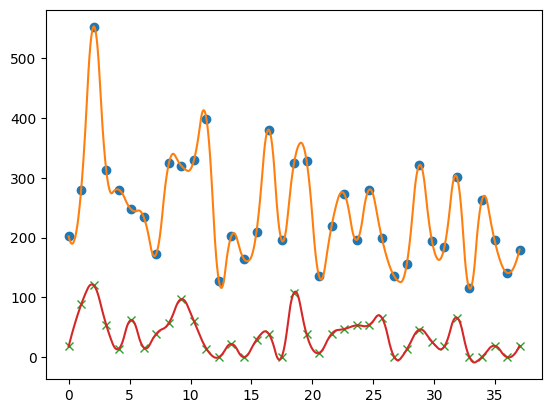

X_train.shape (900, 8)
y_train.shape (900,)
X_test.shape (100, 8)
y_test.shape (100,)
ERROR1 START
'LinearRegression' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (900, 8)
y_train.shape (900,)
X_test.shape (100, 8)
y_test.shape (100,)
X_train.shape (900, 8)
y_train.shape (900,)
X_test.shape (100, 8)
y_test.shape (100,)
ERROR1 START
'RidgeCV' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (900, 8)
y_train.shape (900,)
X_test.shape (100, 8)
y_test.shape (100,)
ERROR1 START
'LassoCV' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (900, 8)
y_train.shape (900,)
X_test.shape (100, 8)
y_test.shape (100,)
ERROR1 START
'LassoLarsCV' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (900, 8)
y_train.shape (900,)
X_test.shape (100, 8)
y_test.shape (100,)
ERROR2 START
'KNeighborsRegressor' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERR

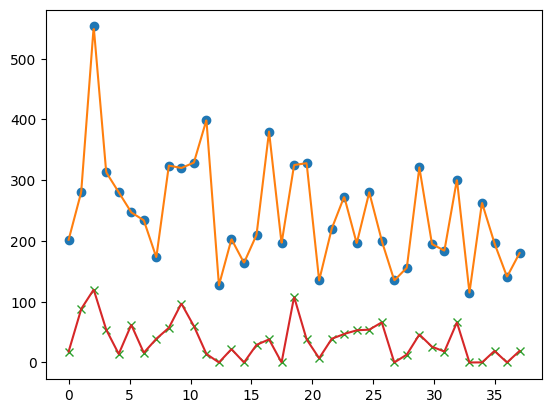

X_train.shape (900, 8)
y_train.shape (900,)
X_test.shape (100, 8)
y_test.shape (100,)
ERROR1 START
'LinearRegression' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (900, 8)
y_train.shape (900,)
X_test.shape (100, 8)
y_test.shape (100,)
X_train.shape (900, 8)
y_train.shape (900,)
X_test.shape (100, 8)
y_test.shape (100,)
ERROR1 START
'RidgeCV' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (900, 8)
y_train.shape (900,)
X_test.shape (100, 8)
y_test.shape (100,)
ERROR1 START
'LassoCV' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (900, 8)
y_train.shape (900,)
X_test.shape (100, 8)
y_test.shape (100,)
ERROR1 START
'LassoLarsCV' object has no attribute 'best_estimator_'
ERROR1 FINISH
X_train.shape (900, 8)
y_train.shape (900,)
X_test.shape (100, 8)
y_test.shape (100,)
ERROR2 START
'KNeighborsRegressor' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERR

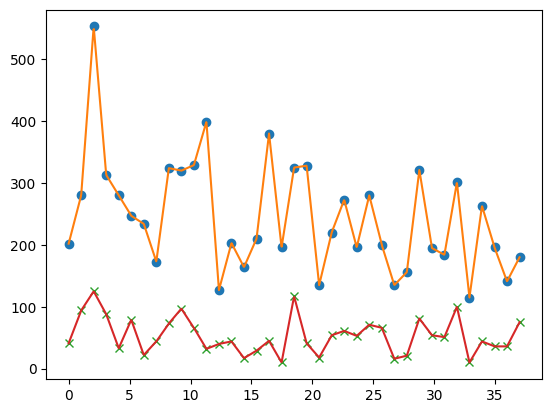

X_train.shape (900, 5)
y_train.shape (900,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (900, 5)
y_train.shape (900,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (900, 5)
y_train.shape (900,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (900, 5)
y_train.shape (900,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (900, 5)
y_train.shape

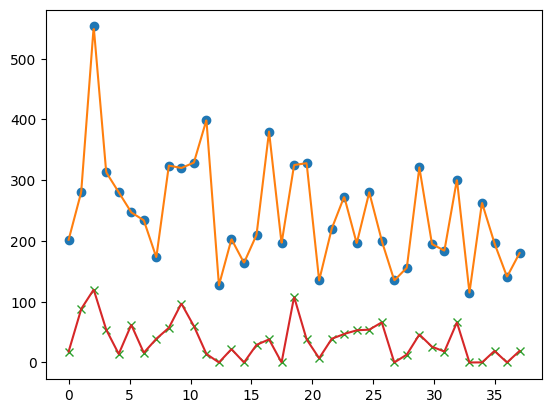

X_train.shape (900, 5)
y_train.shape (900,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (900, 5)
y_train.shape (900,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (900, 5)
y_train.shape (900,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (900, 5)
y_train.shape (900,)
X_test.shape (100, 5)
y_test.shape (100,)
ERROR2 START
'Pipeline' object has no attribute 'coef_'
ERROR2 FINISH
ERROR3 START
unsupported operand type(s) for *: 'NoneType' and 'float'
ERROR3 FINISH
X_train.shape (900, 5)
y_train.shape

In [24]:
top_best = None

exp_fieldnames = [
        'Dataset_name',
        'Group',
        'Method',
        'Criterion',
        'Correlation',
        'Pm',
        'R2',
    
        
        'Augmentation',
        'Data size',
        'Normalization',
        'Equation',
    ]

experiments = [

    compare_models(pr_group=0, n_test=100, norms=True, top_best=top_best, aug_n=1000, aug_pow=2, grid_search=True, scaler='none', verify_forecast=False),          
    compare_models(pr_group=0, n_test=100, norms=True, top_best=top_best, aug_n=1000, aug_pow=1, grid_search=True, scaler='none', verify_forecast=False),
    compare_models(pr_group=1, n_test=100, norms=True, top_best=top_best, aug_n=1000, aug_pow=1, grid_search=True, scaler='normal', verify_forecast=False),
    compare_models(pr_group=2, n_test=100, norms=True, top_best=top_best, aug_n=1000, aug_pow=1, grid_search=True, scaler='normal', verify_forecast=False),
    #compare_models(pr_group=2, n_test=0, norms=True, top_best=top_best),
]

exp_results = []
for ds in experiments:
    #print(ds)
    for k, v in ds.items():
        exp_results.extend(v)
        
exp_results.sort(
    key=lambda row: (row['Dataset_name'], -row['R2'])
)
write_experiment_csv(exp_results, exp_fieldnames, 'experiment')

In [25]:
a = np.array([[1,3],[5,7],
    [-1,-2],[-3,-4]])
b = np.array([2,4,6,8])[:, np.newaxis]
print(a)
print(b)
arr = np.column_stack((a,b))
print(arr)

[[ 1  3]
 [ 5  7]
 [-1 -2]
 [-3 -4]]
[[2]
 [4]
 [6]
 [8]]
[[ 1  3  2]
 [ 5  7  4]
 [-1 -2  6]
 [-3 -4  8]]
